# Setup

# Effect of number of candidate blooming bacteria on Bray-Curtis distance
## shown in supplementary figure 1
We test the effect of how many sequences we use for filtering on between experiment Bray-Curtis distance. Steps are:
1. Load the datasets (AG, UK-Twins, PGP, Whole grain feces) and join to a single experiment
2. Iterate over subsets (0-21 sOTUs) of the candidate blooming bacteria (which are sorted in the fasta file by fold change)
3. For each selected subset, filter it from the experiment, renormalize the reads without the blooming bacteria
4. Randomly select a sample from each study, and calculate the Bray-Curtis distance between samples from different studies (iterate step 2000 times)
6. Plot the result.

We expect the filtering to reduce the shipped (AG) - fresh frozen (PGP,Whole grain feces, UK-Twins) distances, while not to change the fresh-frozen to fresh-frozen distances.

In [2]:
# plots inside the notebook
%matplotlib notebook

# load modules used in the analysis
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# heatsequer module is available from:
# https://github.com/amnona/heatsequer
import heatsequer as hs

/Users/amnon/anaconda/envs/qt5test/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/Users/amnon/anaconda/envs/qt5test/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/Users/amnon/anaconda/envs/qt5test/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new 

('loading cooldb',)
('cooldb loaded',)
('loading bactdb',)
('bactdb loaded',)
('loading supercooldb',)
('supercooldb loaded',)


In [3]:
# set display to full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Loading all experimental data

## american gut

In [4]:
ag=hs.load('../data/ag-6-2016.clean.min100.withtax.biom','../data/map.ag-6-2016.txt')

('Loading biom table ../data/ag-6-2016.clean.min100.withtax.biom',)
5ffd56560ea3217b52a6076d5dd5d2f6
('Loading mapping file ../data/map.ag-6-2016.txt',)
('number of samples in map is 9919',)
('number of samples in table is 9919',)
('removing 0 samples',)
('deleted. number of samples in table is now 9919',)
('number of samples in mapping file is now 9919',)
('Samples with 0 reads: 1214',)


In [5]:
# get only fecal
agf=hs.filtersamples(ag,'ENV_MATTER','ENVO:feces')

('7286 Samples left',)


In [6]:
# convert date to number
agf=hs.convertdatefield(agf,'COLLECTION_DATE','date-numeric','%m/%d/%Y')

('1 conversions failed',)


In [7]:
# and sort by collection date
agf=hs.sortsamples(agf,'date-numeric',numeric=True)

In [8]:
# keep only samples with >1000 reads
agf=hs.filterorigreads(agf,1000)

('7073 Samples left',)


## UK twins study

In [9]:
twins=hs.load('../data/twins2.clean.min10.withtax.biom','../data/map.twins2.txt')

('Loading biom table ../data/twins2.clean.min10.withtax.biom',)
d16fcd8fbbae6b25cbd464ab73950ba1
('Loading mapping file ../data/map.twins2.txt',)
('number of samples in map is 1081',)
('number of samples in table is 1046',)
('removing 0 samples',)
('deleted. number of samples in table is now 1046',)
('removing 35 samples from mapping file',)
('number of samples in mapping file is now 1046',)
('Samples with 0 reads: 29',)


In [10]:
# keep only high freq. enough bacteria
twinsf=hs.clusterbacteria(twins,50)

('2564 Bacteria left',)


In [11]:
# keep only samples with >1000 reads
twins=hs.filterorigreads(twins,1000)

('1017 Samples left',)


## PGP

In [12]:
pgp=hs.load('../data/pgp.baylor.clean.withtax.biom','../data/map.pgp.txt')

('Loading biom table ../data/pgp.baylor.clean.withtax.biom',)
7ca155612b152a9b7b20540489072e8e
('Loading mapping file ../data/map.pgp.txt',)
('number of samples in map is 429',)
('number of samples in table is 437',)
('Table sample Fermanagh.Mouth not found in mapping file',)
('Table sample Elmira.Stool not found in mapping file',)
('Table sample Erlandson.Stool not found in mapping file',)
('Table sample Innkeeper.Forehead not found in mapping file',)
('Table sample Tewmac.Mouth not found in mapping file',)
('Table sample Pinrock.Rightpalm not found in mapping file',)
('Table sample Lippokd.Forehead not found in mapping file',)
('Table sample Delmore.Leftpalm not found in mapping file',)
('Table sample Goddu.Forehead not found in mapping file',)
('Table sample Menekish.Stool not found in mapping file',)
('removing 10 samples',)
('deleted. number of samples in table is now 427',)
('removing 2 samples from mapping file',)
('number of samples in mapping file is now 427',)
('Samples with 

In [13]:
# only fecal samples
pgpf=hs.filtersamples(pgp,'#SampleID','Stool',exact=False)

('80 Samples left',)


In [14]:
# keep only samples with >1000 reads
pgpf=hs.filterorigreads(pgpf,1000)

('79 Samples left',)


## Ercolini whole grain feces

In [15]:
erc=hs.load('../data/ercolini.feces.clean.withtax.biom','../data/map.ercolini.txt')

('Loading biom table ../data/ercolini.feces.clean.withtax.biom',)
2ad21c8bdf0b14e5c60dc29494838d15
('Loading mapping file ../data/map.ercolini.txt',)
('number of samples in map is 96',)
('number of samples in table is 93',)
('removing 0 samples',)
('deleted. number of samples in table is now 93',)
('removing 3 samples from mapping file',)
('number of samples in mapping file is now 93',)
('Samples with 0 reads: 4',)


In [16]:
# only fecal samples
ercf=hs.filtersamples(erc,'env_matter','ENVO:feces')

('89 Samples left',)


In [17]:
# keep only samples with >1000 reads
ercf=hs.filterorigreads(ercf,1000)

('88 Samples left',)


## Join all experiments to single experiment
keep only the original experiment field to make it faster

In [18]:
# join the experiments
allf=hs.joinexperiments(pgpf,twinsf)
allf=hs.joinexperiments(allf,ercf)
allf=hs.joinexperiments(allf,agf)

In [19]:
# remove the mapping fields except origexp (to make it faster)
hs.filtermapfields(allf,['origexp'],inplace=True)

# Calculate the mean Bray-Curtis distance for filtering levels
iterate over number of bloom bacteria to filter (according to their order in the fasta file):

Repeat 2000 times:
    
Randomly select a pair of bacteria and calculate Bray-Curtis distance between them

In [20]:
# load the list of blooming bacteria (sorted by importance)
newbloom,_=hs.readfastaseqs('../data/newbloom.all.fa')

<IPython.core.display.Javascript object>


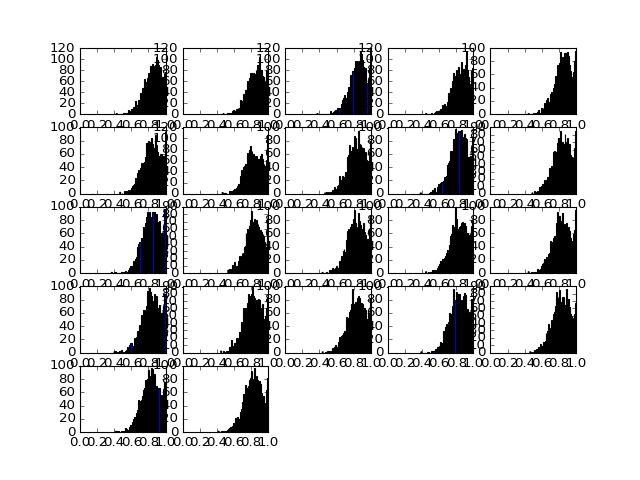

0
calculating distances
1
calculating distances
2
calculating distances
3
calculating distances
4
calculating distances
5
calculating distances
6
calculating distances
7
calculating distances
8
calculating distances
9
calculating distances
10
calculating distances
11
calculating distances
12
calculating distances
13
calculating distances
14
calculating distances
15
calculating distances
16
calculating distances
17
calculating distances
18
calculating distances
19
calculating distances
20
calculating distances
21
calculating distances


<IPython.core.display.Javascript object>


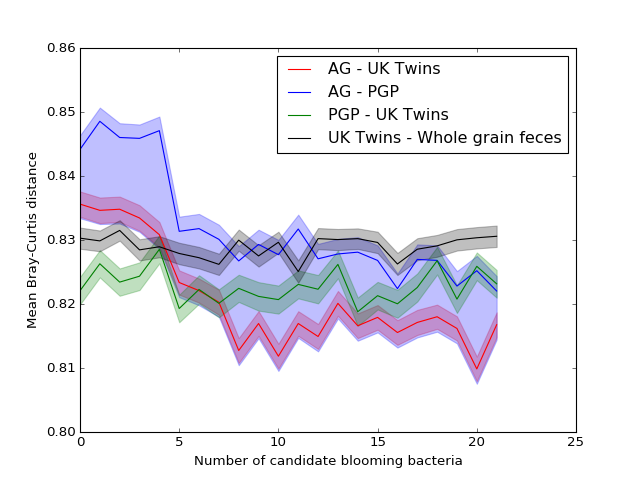

In [21]:
# store the number of sOTUs used for the filtering
allx=[]
# store the mean and serr for ag - uk twin comparison
agtwin=[]
agtwinserr=[]
# store the mean and serr for ag - pgp comparison
agpgp=[]
agpgpserr=[]
# store the mean and serr for pgp - uk twin comparison
pgptwin=[]
pgptwinserr=[]
# store the mean and serr for uk twin - whole grain feces comparison
twinerco=[]
twinercoserr=[]

plt.figure()
# get the sample positions for each experiment
agpos=hs.findsamples(allf,'origexp','ag-6-2016.clean.min100.withtax.biom')
twinspos=hs.findsamples(allf,'origexp','twins2.clean.min10.withtax.biom')
pgppos=hs.findsamples(allf,'origexp','pgp.baylor.clean.withtax.biom')
ercopos=hs.findsamples(allf,'origexp','ercolini.feces.clean.withtax.biom')
for numbloom in range(22):
    print(numbloom)
    # filter the first numbloom sOTUs from all samples
    tt=hs.filterseqs(allf,newbloom[:numbloom],exclude=True)
    # and renormalize without them (to 10k reads/sample)
    tt=hs.normalizereads(tt)

    print('calculating distances')
    
    allagtwin=[]
    allagpgp=[]
    allpgptwin=[]
    alltwinerco=[]
    for crepeat in range(2000):
        # get random sample from each study
        cag=agpos[np.random.randint(len(agpos))]
        cerco=ercopos[np.random.randint(len(ercopos))]
        ctwin=twinspos[np.random.randint(len(twinspos))]
        cpgp=pgppos[np.random.randint(len(pgppos))]

        # calculate sample-sample Bray-Curtis distance
        allagtwin.append(hs.calcdist(tt.data[:,cag],tt.data[:,ctwin]))
        allpgptwin.append(hs.calcdist(tt.data[:,ctwin],tt.data[:,cpgp]))
        alltwinerco.append(hs.calcdist(tt.data[:,ctwin],tt.data[:,cerco]))
        allagpgp.append(hs.calcdist(tt.data[:,cag],tt.data[:,cpgp]))
    # plot the histogram of distances (ag-pgp)
    plt.subplot(5,5,numbloom+1)
    plt.hist(allagpgp,50)
    plt.xlim([0,1])
    # store the mean and standard error for each study-study comparison
    allx.append(numbloom)
    agtwin.append(np.mean(allagtwin))
    agtwinserr.append(np.std(allagtwin)/np.sqrt(len(allagtwin)))
    agpgp.append(np.mean(allagpgp))
    agpgpserr.append(np.std(allagpgp)/np.sqrt(len(allagpgp)))
    pgptwin.append(np.mean(allpgptwin))
    pgptwinserr.append(np.std(allpgptwin)/np.sqrt(len(allpgptwin)))
    twinerco.append(np.mean(alltwinerco))
    twinercoserr.append(np.std(alltwinerco)/np.sqrt(len(alltwinerco)))

# plot the summary
agtwin=np.array(agtwin)
agpgp=np.array(agpgp)
pgptwin=np.array(pgptwin)
twinerco=np.array(twinerco)
agtwinserr=np.array(agtwinserr)
agpgpserr=np.array(agpgpserr)
pgptwinserr=np.array(pgptwinserr)
twinercoserr=np.array(twinercoserr)

plt.figure()
plt.fill_between(allx, agtwin+agtwinserr, agtwin-agtwinserr, alpha=0.25,color='r')
plt.plot(allx,agtwin,color='r')
plt.fill_between(allx, agpgp+agpgpserr, agtwin-agpgpserr, alpha=0.25,color='b')
plt.plot(allx,agpgp,color='b')
plt.fill_between(allx, pgptwin+pgptwinserr, pgptwin-pgptwinserr, alpha=0.25,color='g')
plt.plot(allx,pgptwin,color='g')
plt.fill_between(allx, twinerco+twinercoserr, twinerco-twinercoserr, alpha=0.25,color='k')
plt.plot(allx,twinerco,color='k')

plt.legend(['AG - UK Twins','AG - PGP','PGP - UK Twins','UK Twins - Whole grain feces'])
plt.xlabel('Number of candidate blooming bacteria')
plt.ylabel('Mean Bray-Curtis distance')

In [ ]:
plt.savefig('../results/sup_1_distance_vs_number_bloom_with_serr.pdf')